In [8]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
time_step = []
series = []

with open('Pollution_new.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    step = 0
    
    for row in reader:
        time_step.append(step)
        series.append(float(row[1]))
        step += 1

time_step = np.array(time_step)
series = np.array(series)

In [20]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[: -1], window[-1: ]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [6]:
def plot_series(time, series, start=0, end = None, sign = '-'):
    plt.plot(time[start:end], series[start:end], sign)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

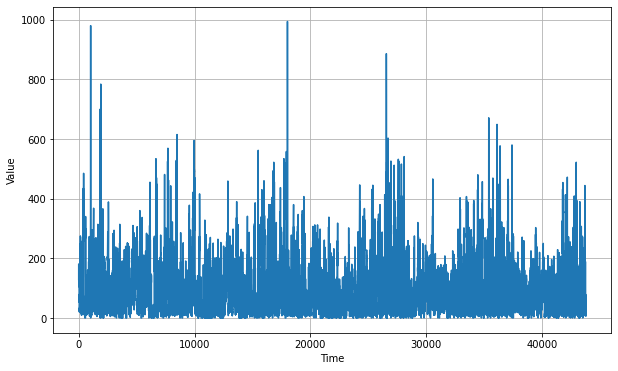

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_step, series)

In [12]:
split_time = 365 * 24 * 4
time_train = time_step[: split_time]
x_train = series[: split_time]
time_valid = time_step[split_time: ]
x_valid = series[split_time: ]

In [25]:
window_size = 64
batch_size = 90
shuffle_buffer = 100

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

In [26]:
training = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

model.compile(loss = 'mse',
              optimizer = 'adam')
history = model.fit(training,
              epochs = 150)

Epoch 1/150
389/389 [==============================] - 25s 55ms/step - loss: 1973.9460
Epoch 2/150
389/389 [==============================] - 20s 51ms/step - loss: 1108.8539
Epoch 3/150
389/389 [==============================] - 21s 54ms/step - loss: 957.9973
Epoch 4/150
389/389 [==============================] - 20s 52ms/step - loss: 869.9155
Epoch 5/150
389/389 [==============================] - 21s 54ms/step - loss: 896.8663
Epoch 6/150
389/389 [==============================] - 21s 54ms/step - loss: 808.5981
Epoch 7/150
389/389 [==============================] - 22s 56ms/step - loss: 845.4235
Epoch 8/150
389/389 [==============================] - 21s 53ms/step - loss: 796.8071
Epoch 9/150
389/389 [==============================] - 21s 53ms/step - loss: 838.9413
Epoch 10/150
389/389 [==============================] - 21s 53ms/step - loss: 793.7713
Epoch 11/150
389/389 [==============================] - 21s 54ms/step - loss: 794.2582
Epoch 12/150
389/389 [============================

In [27]:
df_his = pd.DataFrame(history.history)
df_his.tail()

,loss
145,660.287354
146,630.625305
147,641.054993
148,632.099243
149,630.128113


In [31]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size: ]
results = np.array(forecast)[:, 0, 0]

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.200956

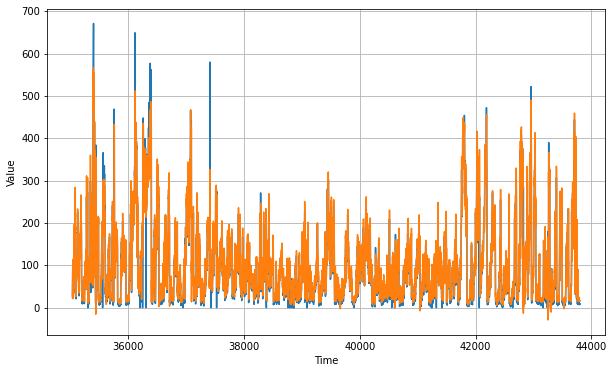

In [34]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [48]:
window_size = 3
batch_size = 3
shuffle_buffer = 1000

def window_dataset1(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[: -1], window[-1: ]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds
train_set = window_dataset1(x_train, window_size, batch_size, shuffle_buffer)

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss = 'mse',
              optimizer = 'adam')
history = model.fit(train_set,
                    epochs = 100)

Epoch 1/100
11679/11679 [==============================] - 40s 3ms/step - loss: 1138.2272
Epoch 2/100
11679/11679 [==============================] - 37s 3ms/step - loss: 973.8866
Epoch 3/100
11679/11679 [==============================] - 39s 3ms/step - loss: 950.3758
Epoch 4/100
11679/11679 [==============================] - 40s 3ms/step - loss: 979.4493
Epoch 5/100
11679/11679 [==============================] - 44s 4ms/step - loss: 906.5031
Epoch 6/100
11679/11679 [==============================] - 43s 4ms/step - loss: 904.7562
Epoch 7/100
11679/11679 [==============================] - 41s 4ms/step - loss: 881.6979
Epoch 8/100
11679/11679 [==============================] - 41s 3ms/step - loss: 962.1255
Epoch 9/100
11679/11679 [==============================] - 39s 3ms/step - loss: 1002.7758
Epoch 10/100
11679/11679 [==============================] - 39s 3ms/step - loss: 1024.6644
Epoch 11/100
11679/11679 [==============================] - 40s 3ms/step - loss: 995.8021
Epoch 12/100
116

KeyboardInterrupt: 

In [51]:
series.shape

(43799,)